# Imports

In [13]:
import numpy as np
from pyod.models.iforest import IForest
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

In [6]:

# Parameters
n_train = 200  # Number of training samples
n_test = 100   # Number of testing samples
n_features = 10  # Number of features
contamination = 0.1  # Proportion of anomalies

# Generate data
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train,
    n_test=n_test,
    n_features=n_features,
    contamination=contamination,
    random_state=42
)



In [7]:
# Initialize the Isolation Forest detector
clf = IForest(contamination=contamination, random_state=42)

# Fit the model
clf.fit(X_train)


IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=42,
    verbose=0)

In [8]:
# Predict on training data
y_train_pred = clf.labels_  # Binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # Raw outlier scores

# Predict on test data
y_test_pred = clf.predict(X_test)  # Binary labels
y_test_scores = clf.decision_function(X_test)  # Outlier scores


In [9]:
# Evaluate on training data
print("\nOn Training Data:")
evaluate_print("Isolation Forest", y_train, y_train_scores)

# Evaluate on test data
print("\nOn Test Data:")
evaluate_print("Isolation Forest", y_test, y_test_scores)



On Training Data:
Isolation Forest ROC:1.0, precision @ rank n:1.0

On Test Data:
Isolation Forest ROC:1.0, precision @ rank n:1.0


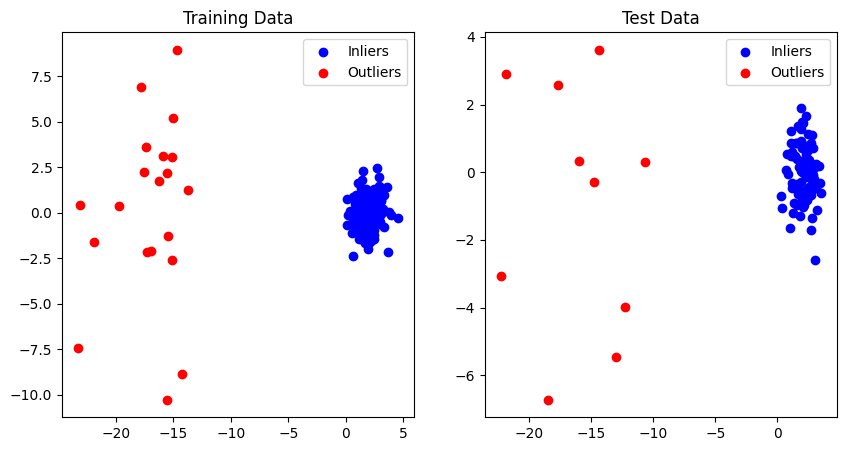

In [12]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Plotting
plt.figure(figsize=(10, 5))

# Training data
plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[y_train == 0][:, 0], X_train_pca[y_train == 0][:, 1],
            c='blue', label='Inliers')
plt.scatter(X_train_pca[y_train == 1][:, 0], X_train_pca[y_train == 1][:, 1],
            c='red', label='Outliers')
plt.title('Training Data')
plt.legend()

# Test data
plt.subplot(1, 2, 2)
plt.scatter(X_test_pca[y_test == 0][:, 0], X_test_pca[y_test == 0][:, 1],
            c='blue', label='Inliers')
plt.scatter(X_test_pca[y_test == 1][:, 0], X_test_pca[y_test == 1][:, 1],
            c='red', label='Outliers')
plt.title('Test Data')
plt.legend()

plt.show()


In [14]:
# Create DataFrames for better visualization
df_train = pd.DataFrame(X_train, columns=[f'Feature_{i+1}' for i in range(X_train.shape[1])])
df_test = pd.DataFrame(X_test, columns=[f'Feature_{i+1}' for i in range(X_test.shape[1])])

# Add the target labels to the DataFrames
df_train['Label'] = y_train
df_test['Label'] = y_test

# Display the first few rows of the training data
print("Training Data:")
print(df_train.head())

# Display the first few rows of the test data
print("\nTest Data:")
print(df_test.head())


Training Data:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   6.433659   5.509168   5.044698   7.708065   5.924536   5.259220   
1   6.185903   6.094106   7.166309   7.227191   4.054708   6.481270   
2   5.980496   6.283567   6.332584   6.663924   5.766002   5.976202   
3   5.402579   5.379207   6.756743   7.260796   5.706368   6.299529   
4   6.257606   4.888690   4.262685   5.167448   6.137731   6.258562   

   Feature_7  Feature_8  Feature_9  Feature_10  Label  
0   5.293991   5.671262   5.615091    6.130929    0.0  
1   5.799782   5.869309   4.822564    7.185931    0.0  
2   6.075867   6.530090   5.888170    5.973527    0.0  
3   5.048405   5.673764   5.643704    7.215648    0.0  
4   6.594855   4.535246   6.450184    6.020338    0.0  

Test Data:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   6.173238   5.723545   4.464880   5.937299   8.595721   5.007491   
1   7.086791   5.336841   5.914986   6.761776   7.683098   5.068036 

# Semi Supervised SVM Test

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from pyod.models.ocsvm import OCSVM
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM



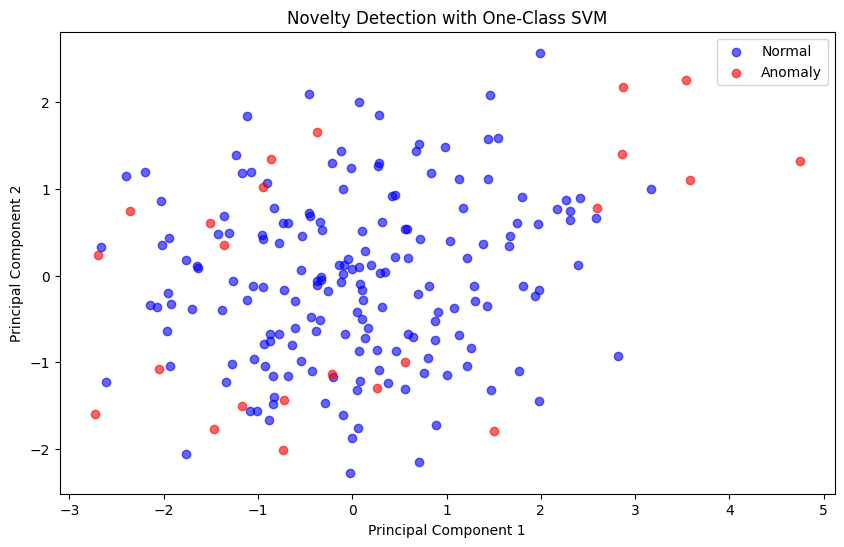

In [54]:
# Generate synthetic data
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    weights=[0.99],
    flip_y=0,
    random_state=42,
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# For semi-supervised learning, use only normal data (y=0) for training
X_train_normal = X_train[y_train == 0]

# Apply PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_normal)
X_test_pca = pca.transform(X_test)

# Scale the training and test data for better performance
scaler = StandardScaler()
X_train_normal_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the One-Class SVM model with tuned hyperparameters
# Adjust nu and gamma based on your data and desired sensitivity
clf = OCSVM(kernel='rbf', nu=0.1, gamma=0.05)
clf.fit(X_train_normal_scaled)

# Predict on the test set using the scaled data
y_test_pred = clf.predict(X_test_scaled)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(
    X_test_pca[y_test_pred == 0, 0],
    X_test_pca[y_test_pred == 0, 1],
    c="blue",
    label="Normal",
    alpha=0.6,
)
plt.scatter(
    X_test_pca[y_test_pred == 1, 0],
    X_test_pca[y_test_pred == 1, 1],
    c="red",
    label="Anomaly",
    alpha=0.6,
)
plt.title("Novelty Detection with One-Class SVM")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


In [31]:
# Create a DataFrame for the original training data (before filtering)
df_train = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
df_train['label'] = y_train
print("Training Data (first 5 rows):")
print(df_train.head())
print("\nLabel distribution in the training data:")
print(df_train['label'].value_counts())

# Create a DataFrame for the test data
df_test = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])
df_test['label'] = y_test
print("\nTest Data (first 5 rows):")
print(df_test.head())
print("\nLabel distribution in the test data:")
print(df_test['label'].value_counts())

# (Optional) Create a DataFrame for the filtered training data (normal only)
df_train_normal = pd.DataFrame(X_train_normal, columns=[f'feature_{i}' for i in range(X_train_normal.shape[1])])
# Since these are only normal samples, we know the label is 0 for all entries.
df_train_normal['label'] = 0
print("\nFiltered Training Data (Normal Only, first 5 rows):")
print(df_train_normal.head())
print("\nLabel distribution in the filtered training data (normal only):")
print(df_train_normal['label'].value_counts())

Training Data (first 5 rows):
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.566610   0.043515  -1.187984  -0.296607   0.386323   0.241322   
1  -0.545366  -0.034564  -1.687124  -1.400071   1.592025  -0.103812   
2   2.364988  -0.916321  -0.285316   0.307613   0.424067  -0.524567   
3   0.094433   0.458389  -1.553788  -0.381138  -1.208859   0.603713   
4   2.318869  -0.665422  -0.176166   0.668840  -0.994429   0.671945   

   feature_6  feature_7  feature_8  feature_9  label  
0   0.558140  -2.529560  -0.204471  -1.151014      0  
1   0.905718   2.345624  -0.587738  -1.180460      0  
2  -0.836921  -0.140375   0.039447   1.352203      0  
3  -1.104775   0.988609  -0.565937   1.401500      0  
4   0.721903  -1.269999   0.249548   0.384202      0  

Label distribution in the training data:
label
0    792
1      8
Name: count, dtype: int64

Test Data (first 5 rows):
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   3.552161   0.365394

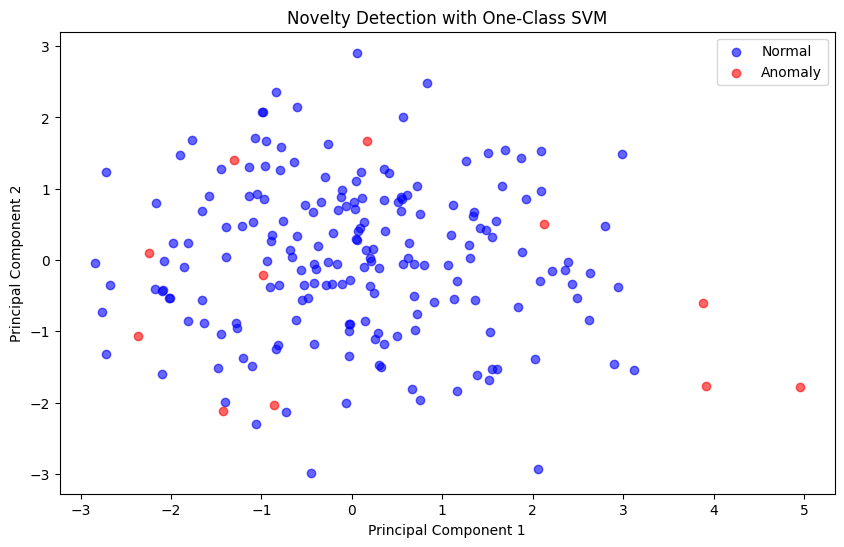

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# Generate synthetic data
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    weights=[0.99],
    flip_y=0,
    random_state=42,
)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# For semi-supervised learning, use only normal data (y=0) for training
X_train_normal = X_train[y_train == 0]

# Scale the training and test data for better performance
scaler = StandardScaler()
X_train_normal_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the One-Class SVM model with tuned hyperparameters
clf = OneClassSVM(kernel='rbf', nu=0.01, gamma=0.05)
clf.fit(X_train_normal_scaled)

# Predict on the test set using the scaled data
y_test_pred = clf.predict(X_test_scaled)
# Remap predictions: OneClassSVM returns 1 for inliers (normal) and -1 for outliers (anomalies).
# We remap these so that 0 indicates normal and 1 indicates anomaly.
y_test_pred_mapped = np.where(y_test_pred == 1, 0, 1)

# Apply PCA to reduce dimensionality for visualization on the scaled data
pca = PCA(n_components=2)
# Fit PCA on the scaled training data (normal only)
X_train_normal_scaled_pca = pca.fit_transform(X_train_normal_scaled)
# Transform the scaled test data
X_test_scaled_pca = pca.transform(X_test_scaled)

# Plot the results using PCA on scaled data
plt.figure(figsize=(10, 6))
plt.scatter(
    X_test_scaled_pca[y_test_pred_mapped == 0, 0],
    X_test_scaled_pca[y_test_pred_mapped == 0, 1],
    c="blue",
    label="Normal",
    alpha=0.6,
)
plt.scatter(
    X_test_scaled_pca[y_test_pred_mapped == 1, 0],
    X_test_scaled_pca[y_test_pred_mapped == 1, 1],
    c="red",
    label="Anomaly",
    alpha=0.6,
)
plt.title("Novelty Detection with One-Class SVM")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


Confusion Matrix:
[[1611  185]
 [   0  204]]

Counts:
True Normal (TN): 1611
False Anomaly (FP): 185
False Normal (FN): 0
True Anomaly (TP): 204


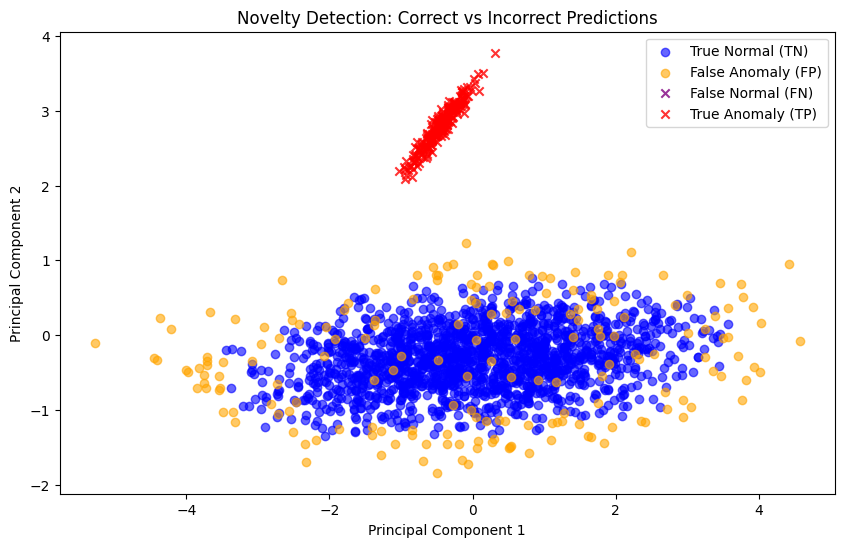

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix

# -------------------------------
# Data Generation and Preprocessing
# -------------------------------

# Generate synthetic data
X, y = make_classification(
    n_samples=10000,
    n_features=3,
    n_informative=3,
    n_redundant=0,
    n_clusters_per_class=1,
    weights=[0.90],  # About 99% of samples are normal (class 0) and 1% anomalies (class 1)
    flip_y=0,
    random_state=654,
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# For semi-supervised learning, use only normal data (y=0) for training
X_train_normal = X_train[y_train == 0]

# Scale the training and test data for better performance
scaler = StandardScaler()
X_train_normal_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# Model Training and Prediction
# -------------------------------

# Initialize and train the One-Class SVM model with tuned hyperparameters
clf = OneClassSVM(kernel='rbf', nu=0.1, gamma="auto")
clf.fit(X_train_normal_scaled)

# Predict on the test set using the scaled data
y_test_pred = clf.predict(X_test_scaled)
# Note: One-Class SVM returns 1 for inliers (normal) and -1 for outliers (anomalies).
# Remap so that 0 indicates normal and 1 indicates anomaly.
y_test_pred_mapped = np.where(y_test_pred == 1, 0, 1)

# -------------------------------
# Visualization Preparation (PCA on Scaled Data)
# -------------------------------

# For visualization, apply PCA on the scaled test data to reduce it to 2 dimensions.
pca = PCA(n_components=2)
X_test_scaled_pca = pca.fit_transform(X_test_scaled)

# -------------------------------
# Evaluation: Confusion Matrix and Count Grid
# -------------------------------

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_mapped)
print("Confusion Matrix:")
print(cm)

# Identify indices for each category:
# - True Normal (TN): Ground truth 0 and predicted 0.
# - False Positive (FP): Ground truth 0 but predicted as anomaly (1).
# - False Negative (FN): Ground truth 1 but predicted as normal (0).
# - True Anomaly (TP): Ground truth 1 and predicted as anomaly (1).
tn_idx = (y_test == 0) & (y_test_pred_mapped == 0)
fp_idx = (y_test == 0) & (y_test_pred_mapped == 1)
fn_idx = (y_test == 1) & (y_test_pred_mapped == 0)
tp_idx = (y_test == 1) & (y_test_pred_mapped == 1)

tn_count = np.sum(tn_idx)
fp_count = np.sum(fp_idx)
fn_count = np.sum(fn_idx)
tp_count = np.sum(tp_idx)

print("\nCounts:")
print("True Normal (TN):", tn_count)
print("False Anomaly (FP):", fp_count)
print("False Normal (FN):", fn_count)
print("True Anomaly (TP):", tp_count)

# -------------------------------
# Visualization: Correct vs. Incorrect Predictions
# -------------------------------

plt.figure(figsize=(10, 6))

# Plot True Normals (correct normals)
plt.scatter(
    X_test_scaled_pca[tn_idx, 0],
    X_test_scaled_pca[tn_idx, 1],
    c="blue",
    marker="o",
    label="True Normal (TN)",
    alpha=0.6,
)

# Plot False Positives: normal samples incorrectly flagged as anomalies
plt.scatter(
    X_test_scaled_pca[fp_idx, 0],
    X_test_scaled_pca[fp_idx, 1],
    c="orange",
    marker="o",
    label="False Anomaly (FP)",
    alpha=0.6,
)

# Plot False Negatives: anomalous samples incorrectly classified as normal
plt.scatter(
    X_test_scaled_pca[fn_idx, 0],
    X_test_scaled_pca[fn_idx, 1],
    c="purple",
    marker="x",
    label="False Normal (FN)",
    alpha=0.8,
)

# Plot True Anomalies (correct anomalies)
plt.scatter(
    X_test_scaled_pca[tp_idx, 0],
    X_test_scaled_pca[tp_idx, 1],
    c="red",
    marker="x",
    label="True Anomaly (TP)",
    alpha=0.8,
)

plt.title("Novelty Detection: Correct vs Incorrect Predictions")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()



Confusion Matrix:
[[1628  177]
 [  77  118]]

Counts:
True Normal (TN): 1628
False Anomaly (FP): 177
False Normal (FN): 77
True Anomaly (TP): 118


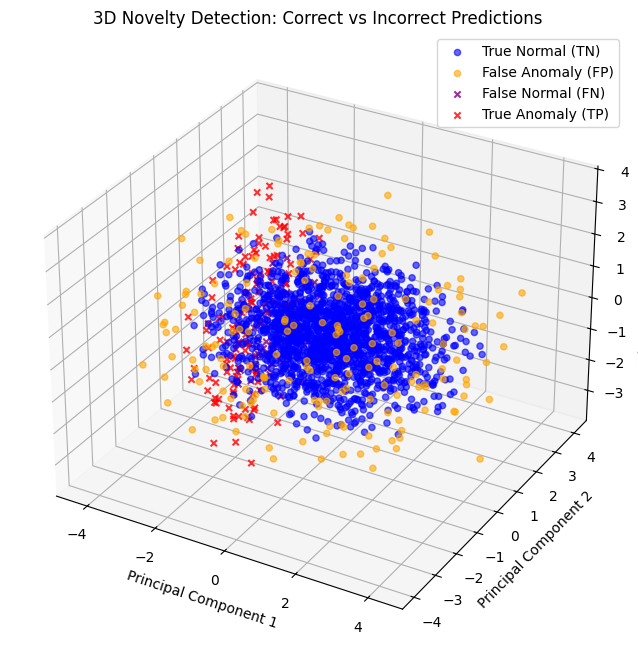

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix

# -------------------------------
# Data Generation and Preprocessing
# -------------------------------

# Generate synthetic data (3 features)
X, y = make_classification(
    n_samples=10000,
    n_features=5,
    n_informative=5,
    n_redundant=0,
    n_clusters_per_class=1,
    weights=[0.90],  # About 90% of samples are normal (class 0) and 10% anomalies (class 1)
    flip_y=0,
    random_state=654,
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# For semi-supervised learning, use only normal data (y=0) for training
X_train_normal = X_train[y_train == 0]

# Scale the training and test data for better performance
scaler = StandardScaler()
X_train_normal_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# Model Training and Prediction
# -------------------------------

# Initialize and train the One-Class SVM model with tuned hyperparameters
clf = OneClassSVM(kernel='rbf', nu=0.1, gamma="auto")
clf.fit(X_train_normal_scaled)

# Predict on the test set using the scaled data
y_test_pred = clf.predict(X_test_scaled)
# One-Class SVM returns 1 for inliers (normal) and -1 for outliers (anomalies).
# Remap so that 0 indicates normal and 1 indicates anomaly.
y_test_pred_mapped = np.where(y_test_pred == 1, 0, 1)

# -------------------------------
# Evaluation: Confusion Matrix and Count Grid
# -------------------------------

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_mapped)
print("Confusion Matrix:")
print(cm)

# Identify indices for each category:
# - True Normal (TN): Ground truth 0 and predicted 0.
# - False Positive (FP): Ground truth 0 but predicted as anomaly (1).
# - False Negative (FN): Ground truth 1 but predicted as normal (0).
# - True Anomaly (TP): Ground truth 1 and predicted as anomaly (1).
tn_idx = (y_test == 0) & (y_test_pred_mapped == 0)
fp_idx = (y_test == 0) & (y_test_pred_mapped == 1)
fn_idx = (y_test == 1) & (y_test_pred_mapped == 0)
tp_idx = (y_test == 1) & (y_test_pred_mapped == 1)

tn_count = np.sum(tn_idx)
fp_count = np.sum(fp_idx)
fn_count = np.sum(fn_idx)
tp_count = np.sum(tp_idx)

print("\nCounts:")
print("True Normal (TN):", tn_count)
print("False Anomaly (FP):", fp_count)
print("False Normal (FN):", fn_count)
print("True Anomaly (TP):", tp_count)

# -------------------------------
# Visualization Preparation (PCA on Scaled Data for 3D Plot)
# -------------------------------

# Although the data is already 3D, applying PCA can help align the axes for visualization.
pca = PCA(n_components=3)
X_test_scaled_pca = pca.fit_transform(X_test_scaled)

# -------------------------------
# Visualization: Correct vs. Incorrect Predictions in 3D
# -------------------------------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot True Normals (correct normals)
ax.scatter(
    X_test_scaled_pca[tn_idx, 0],
    X_test_scaled_pca[tn_idx, 1],
    X_test_scaled_pca[tn_idx, 2],
    c="blue",
    marker="o",
    label="True Normal (TN)",
    alpha=0.6,
)

# Plot False Positives: normal samples incorrectly flagged as anomalies
ax.scatter(
    X_test_scaled_pca[fp_idx, 0],
    X_test_scaled_pca[fp_idx, 1],
    X_test_scaled_pca[fp_idx, 2],
    c="orange",
    marker="o",
    label="False Anomaly (FP)",
    alpha=0.6,
)

# Plot False Negatives: anomalous samples incorrectly classified as normal
ax.scatter(
    X_test_scaled_pca[fn_idx, 0],
    X_test_scaled_pca[fn_idx, 1],
    X_test_scaled_pca[fn_idx, 2],
    c="purple",
    marker="x",
    label="False Normal (FN)",
    alpha=0.8,
)

# Plot True Anomalies (correct anomalies)
ax.scatter(
    X_test_scaled_pca[tp_idx, 0],
    X_test_scaled_pca[tp_idx, 1],
    X_test_scaled_pca[tp_idx, 2],
    c="red",
    marker="x",
    label="True Anomaly (TP)",
    alpha=0.8,
)

ax.set_title("3D Novelty Detection: Correct vs Incorrect Predictions")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.legend()

plt.show()


In [18]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio  # Import plotly.io to change renderer

# Set the default renderer to 'browser' to avoid nbformat issues
pio.renderers.default = "browser"

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix

# -------------------------------
# Data Generation and Preprocessing
# -------------------------------

# Generate synthetic data (3 features)
X, y = make_classification(
    n_samples=10000,
    n_features=4,
    n_informative=4,
    n_redundant=0,
    n_clusters_per_class=1,
    weights=[0.90],  # About 90% of samples are normal (class 0) and 10% anomalies (class 1)
    flip_y=0,
    random_state=654,
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# For semi-supervised learning, use only normal data (y=0) for training
X_train_normal = X_train[y_train == 0]

# Scale the training and test data for better performance
scaler = StandardScaler()
X_train_normal_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# Model Training and Prediction
# -------------------------------

# Initialize and train the One-Class SVM model with tuned hyperparameters
clf = OneClassSVM(kernel='rbf', nu=0.1, gamma="auto")
clf.fit(X_train_normal_scaled)

# Predict on the test set using the scaled data
y_test_pred = clf.predict(X_test_scaled)
# One-Class SVM returns 1 for inliers (normal) and -1 for outliers (anomalies).
# Remap so that 0 indicates normal and 1 indicates anomaly.
y_test_pred_mapped = np.where(y_test_pred == 1, 0, 1)

# -------------------------------
# Evaluation: Confusion Matrix and Count Grid
# -------------------------------

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_mapped)
print("Confusion Matrix:")
print(cm)

# Identify indices for each category:
# - True Normal (TN): Ground truth 0 and predicted 0.
# - False Positive (FP): Ground truth 0 but predicted as anomaly (1).
# - False Negative (FN): Ground truth 1 but predicted as normal (0).
# - True Anomaly (TP): Ground truth 1 and predicted as anomaly (1).
tn_idx = (y_test == 0) & (y_test_pred_mapped == 0)
fp_idx = (y_test == 0) & (y_test_pred_mapped == 1)
fn_idx = (y_test == 1) & (y_test_pred_mapped == 0)
tp_idx = (y_test == 1) & (y_test_pred_mapped == 1)

tn_count = np.sum(tn_idx)
fp_count = np.sum(fp_idx)
fn_count = np.sum(fn_idx)
tp_count = np.sum(tp_idx)

print("\nCounts:")
print("True Normal (TN):", tn_count)
print("False Anomaly (FP):", fp_count)
print("False Normal (FN):", fn_count)
print("True Anomaly (TP):", tp_count)

# -------------------------------
# Visualization Preparation (PCA on Scaled Data for 3D Plot)
# -------------------------------

# Although the data is already 3D, applying PCA can help align the axes for visualization.
pca = PCA(n_components=3)
X_test_scaled_pca = pca.fit_transform(X_test_scaled)

# -------------------------------
# Interactive Visualization: Correct vs. Incorrect Predictions in 3D using Plotly
# -------------------------------

fig = go.Figure()

# True Normals (correct normals)
fig.add_trace(go.Scatter3d(
    x=X_test_scaled_pca[tn_idx, 0],
    y=X_test_scaled_pca[tn_idx, 1],
    z=X_test_scaled_pca[tn_idx, 2],
    mode='markers',
    marker=dict(size=5, color='blue', symbol='circle'),
    name='True Normal (TN)'
))

# False Positives: normal samples incorrectly flagged as anomalies
fig.add_trace(go.Scatter3d(
    x=X_test_scaled_pca[fp_idx, 0],
    y=X_test_scaled_pca[fp_idx, 1],
    z=X_test_scaled_pca[fp_idx, 2],
    mode='markers',
    marker=dict(size=5, color='orange', symbol='circle'),
    name='False Anomaly (FP)'
))

# False Negatives: anomalous samples incorrectly classified as normal
fig.add_trace(go.Scatter3d(
    x=X_test_scaled_pca[fn_idx, 0],
    y=X_test_scaled_pca[fn_idx, 1],
    z=X_test_scaled_pca[fn_idx, 2],
    mode='markers',
    marker=dict(size=5, color='purple', symbol='x'),
    name='False Normal (FN)'
))

# True Anomalies (correct anomalies)
fig.add_trace(go.Scatter3d(
    x=X_test_scaled_pca[tp_idx, 0],
    y=X_test_scaled_pca[tp_idx, 1],
    z=X_test_scaled_pca[tp_idx, 2],
    mode='markers',
    marker=dict(size=5, color='red', symbol='x'),
    name='True Anomaly (TP)'
))

# Update layout for better visualization
fig.update_layout(
    title="Interactive 3D Novelty Detection: Correct vs Incorrect Predictions",
    scene=dict(
        xaxis_title="Principal Component 1",
        yaxis_title="Principal Component 2",
        zaxis_title="Principal Component 3"
    ),
    legend=dict(x=0.8, y=0.9)
)

fig.show()



Confusion Matrix:
[[1631  164]
 [   8  197]]

Counts:
True Normal (TN): 1631
False Anomaly (FP): 164
False Normal (FN): 8
True Anomaly (TP): 197


In [19]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix

# Set Plotly to open plots in the web browser
pio.renderers.default = "browser"

# -------------------------------
# Data Generation and Preprocessing (4D Data)
# -------------------------------

# Generate synthetic data with 4 features
X, y = make_classification(
    n_samples=10000,
    n_features=4,          # Now using 4 features
    n_informative=4,
    n_redundant=0,
    n_clusters_per_class=1,
    weights=[0.90],        # 90% normal (class 0) and 10% anomalies (class 1)
    flip_y=0,
    random_state=654,
)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# For semi-supervised training, use only normal data (y=0)
X_train_normal = X_train[y_train == 0]

# Scale the data for better performance
scaler = StandardScaler()
X_train_normal_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# Model Training and Prediction
# -------------------------------

# Train a One-Class SVM on the normal data
clf = OneClassSVM(kernel='rbf', nu=0.1, gamma="auto")
clf.fit(X_train_normal_scaled)

# Predict on the test set
y_test_pred = clf.predict(X_test_scaled)
# Remap predictions: 1 -> normal (0), -1 -> anomaly (1)
y_test_pred_mapped = np.where(y_test_pred == 1, 0, 1)

# -------------------------------
# Evaluation: Confusion Matrix and Counts
# -------------------------------

cm = confusion_matrix(y_test, y_test_pred_mapped)
print("Confusion Matrix:")
print(cm)

# Determine indices for each category:
tn_idx = (y_test == 0) & (y_test_pred_mapped == 0)
fp_idx = (y_test == 0) & (y_test_pred_mapped == 1)
fn_idx = (y_test == 1) & (y_test_pred_mapped == 0)
tp_idx = (y_test == 1) & (y_test_pred_mapped == 1)

print("\nCounts:")
print("True Normal (TN):", np.sum(tn_idx))
print("False Anomaly (FP):", np.sum(fp_idx))
print("False Normal (FN):", np.sum(fn_idx))
print("True Anomaly (TP):", np.sum(tp_idx))

# -------------------------------
# Visualization Preparation (PCA to 4 Components)
# -------------------------------

# Reduce the 4D data to 4 principal components.
# We will use the first three for x, y, z and the 4th to encode color.
pca = PCA(n_components=4)
X_test_scaled_pca = pca.fit_transform(X_test_scaled)

# -------------------------------
# Interactive 4D Visualization using Plotly
# -------------------------------
# For each anomaly detection category, we create a trace.
# The first three PCA components represent spatial coordinates,
# while the 4th component is used as the marker color.

fig = go.Figure()

# True Normals (TN)
fig.add_trace(go.Scatter3d(
    x=X_test_scaled_pca[tn_idx, 0],
    y=X_test_scaled_pca[tn_idx, 1],
    z=X_test_scaled_pca[tn_idx, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=X_test_scaled_pca[tn_idx, 3],  # 4th dimension encoded as color
        colorscale='Viridis',
        colorbar=dict(title="4th Dim (TN)"),
    ),
    name='True Normal (TN)'
))

# False Positives (FP) - Normal samples flagged as anomalies
fig.add_trace(go.Scatter3d(
    x=X_test_scaled_pca[fp_idx, 0],
    y=X_test_scaled_pca[fp_idx, 1],
    z=X_test_scaled_pca[fp_idx, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=X_test_scaled_pca[fp_idx, 3],
        colorscale='Viridis',
        showscale=False  # Hide individual color scale for clarity
    ),
    name='False Anomaly (FP)'
))

# False Negatives (FN) - Anomalies misclassified as normal
fig.add_trace(go.Scatter3d(
    x=X_test_scaled_pca[fn_idx, 0],
    y=X_test_scaled_pca[fn_idx, 1],
    z=X_test_scaled_pca[fn_idx, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=X_test_scaled_pca[fn_idx, 3],
        colorscale='Viridis',
        showscale=False
    ),
    name='False Normal (FN)'
))

# True Anomalies (TP)
fig.add_trace(go.Scatter3d(
    x=X_test_scaled_pca[tp_idx, 0],
    y=X_test_scaled_pca[tp_idx, 1],
    z=X_test_scaled_pca[tp_idx, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=X_test_scaled_pca[tp_idx, 3],
        colorscale='Viridis',
        showscale=False
    ),
    name='True Anomaly (TP)'
))

# Update the layout for better visualization
fig.update_layout(
    title="Interactive 4D Visualization (3D space + color for 4th Dimension)",
    scene=dict(
        xaxis_title="Principal Component 1",
        yaxis_title="Principal Component 2",
        zaxis_title="Principal Component 3"
    )
)

fig.show()


Confusion Matrix:
[[1631  164]
 [   8  197]]

Counts:
True Normal (TN): 1631
False Anomaly (FP): 164
False Normal (FN): 8
True Anomaly (TP): 197
